# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Business Understanding

Starbucks is an American multinational Corporation with various chains of coffeehouses and roastery reserves. Seattle, Washington is its headquarter. With over 28,000 locations with an army of employees, Starbucks' mission is "To inspire and nurture the human spirit — one person, one cup and one neighborhood at a time."

To do this, the company has to keep making sure it targets the right customers at the right time through their customer journey. It has a diverse customer base and understanding parterns while segmenting them in order to share various marketing campaigns is a crucial need for the business. For this project, an idea of the usual customers is given for exploration.

To get more understanding of the data, the data needs to be observed and cleaned if needed.

## Problem statement
Starbucks will like to know:
- Who to target for campaigns
- What campaigns to give to these segmented customers

To do this, I have segmented customers into income demographics, explored data with visuals and checked which campaign offer type these segemented customers respond to more.

**Metric:** The solution has a detailed explanation of the patterns and observed offer types which these groups will respond to.

# Data Understanding

#### Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record



In [1]:
# importing relevant libraries
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import seaborn as sns
import math
import json
% matplotlib inline

# reads in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
portfolio # displays data from the portfolio dataframe

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [3]:
portfolio.describe() # displays descriptive statistics for dataframe

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [4]:
portfolio.shape # displays number of rows and columns

(10, 6)

In [5]:
profile.head() # displays data from the profile dataframe

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [6]:
print(profile.duplicated().sum()) # prints number of duplicated data in the dataframe

print(profile.isnull().sum()) # prints number of null values

print(profile.describe()) # displays descriptive statistics for dataframe

profile.info() # displays information about the dataframe

0
age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64
                age  became_member_on         income
count  17000.000000      1.700000e+04   14825.000000
mean      62.531412      2.016703e+07   65404.991568
std       26.738580      1.167750e+04   21598.299410
min       18.000000      2.013073e+07   30000.000000
25%       45.000000      2.016053e+07   49000.000000
50%       58.000000      2.017080e+07   64000.000000
75%       73.000000      2.017123e+07   80000.000000
max      118.000000      2.018073e+07  120000.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [7]:
profile[profile.isnull().any(axis=1)] # displays all null values

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN
10,118,20170824,None,c4863c7985cf408faee930f111475da3,NaN
11,118,20150919,None,148adfcaa27d485b82f323aaaad036bd,NaN
17,118,20170801,None,744d603ef08c4f33af5a61c8c7628d1c,NaN
23,118,20170907,None,2b826eba31074a059d63b0ae8f50b7d5,NaN


In [8]:
transcript.head() # displays transcript data

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [9]:
transcript.info() # displays information about the dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


### Report

- Portfolio dataframe:

For this dataframe, it has 10 row and 6 columns. Nothing seems wrong with this just that the 'channels' column seems to have a list. We won't be using that for this project so it would not be an issue.

Average minimum spend required to complete an offer is 7.70 dollars with an average reward of 4.20 dollars.


- Profile dataframe:


The profile data has 17,000 rows and 5 columns. There are no duplicate values although there are a good number of null values. It is noticed that where age is '118' income is 'NaN' and the age data might have been a mistake while computing this data. Gender for this same group has the value 'None' as well. Which might skew the data a bit. The column 'became_member_on' is not in a time format and would need to be converted. Even the column name is a bit long.

Apart from these the average age is 63 with average income at $65,404. 

- Transcript dataframe:

The data frame can't be explored properly because it has a column which is in dictionary format and needs to be change in order to work with this dataframe.


# Preparing Data

From the data above we can see that base on quality of data (validity, accuracy, completeness, consistency, uniformity), there are some cleaning tasks to complete before exploring the data to uncover patterns.

### Cleaning

- Portfolio:

    Doesn't need to be cleaned
    

- Profile:

    - Delete age = 118 and income = Nan. It can be back or front filled or replaced with averages but to help make sure the results of this project are accurate as possible, I will be deleting them entirely.
    - Delete gender = 'None'. If the value 'None' coresponds with the age '118' and income 'Nan', it will be removed if not, I will assume that the gender wasn't indicated by will.
    - Change the column name 'became_member_on' to a suitable name.
    - Change the values in 'id' column to normal numbers for easy use in the project

In [10]:
profile.dropna(inplace=True) # drops all null values
profile.reset_index(drop=True, inplace=True) # resets index
profile.isnull().sum() # checks if there are null values

age                 0
became_member_on    0
gender              0
id                  0
income              0
dtype: int64

In [11]:
profile[profile.isnull().any(axis=1)] # displays null values

,age,became_member_on,gender,id,income


In [12]:
profile = profile.rename(columns={'became_member_on': 'subscription_date'}) # renames column

profile['subscription_date'] = pd.to_datetime(profile['subscription_date'], format='%Y%m%d') # converts to the appropriate time format

In [13]:
print(profile.dtypes) # prints data types in dataframe

profile.head() # displays dataframe

age                           int64
subscription_date    datetime64[ns]
gender                       object
id                           object
income                      float64
dtype: object


,age,subscription_date,gender,id,income
0,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
1,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
2,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0
3,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0
4,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


- Transcript:
    - re-structure the columns with dictionary and split it into idependent columns in a dataframe.
    - Rename column 'person' to 'id' incase I will be merging the profile and transcript dataframe in the project.
    - Change the values in 'person' column to normal numbers for easy use in the project

In [14]:
# splits the dictionary data format into columns
transcript = pd.concat([transcript.drop(['value'], axis=1), transcript['value'].apply(pd.Series)], axis=1)

In [15]:
transcript.head() # displays the transformed dataframe

,event,person,time,offer id,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [16]:
transcript = transcript.rename(columns={'person': 'id'}) # renames column
portfolio = portfolio.rename(columns={'id': 'offer id'}) # renames column

# separated them into 2 different dataframes. df is mainly for events and merged_df is all dataframes together
df = profile.merge(transcript, on = 'id') # merges profile and transcript dataframe
merged_df = df.merge(portfolio, on = 'offer id') # merges profile and transcript dataframe

In [17]:
def id_mapper(df, column_name):
    '''maps id to user_id
       in the dataframe
    
    INPUT: dataframe and name of column
    OUTPUT: convert long id to short user_id
   '''
    coded_dict = dict()
    cter = 1
    id_encoded = []
    
    # interates through id values and encodes them to user_ids
    for val in df[column_name]:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        id_encoded.append(coded_dict[val]) #appends encoded values to list
    return id_encoded

In [18]:
id_encoded_1 = id_mapper(df, 'id') # calls function and saves results in a variable
id_encoded_2 = id_mapper(merged_df, 'id') # calls function and saves results in a variable

# this is for the merged profile and transcript dataframe
del df['id'] # deletes id column
df['user_id'] = id_encoded_1 # replaces user_id with encoded list
cols = ['age', 'subscription_date', 'gender', 'user_id',  'income', 'event', 'time', 'offer id', 'amount', 'offer_id', 'reward']

df = df[cols] # changes the order of columns


# this is for the merged profile, transcript and portfolio dataframe
del merged_df['id'] # deletes id column
merged_df['user_id'] = id_encoded_2 # replaces user_id with encoded list
cols = ['age', 'subscription_date', 'gender', 'user_id',  'income','event','time','offer id','amount','offer_id','reward_x','channels','difficulty','duration','offer_type','reward_y']

merged_df = merged_df[cols] # changes the order of columns

In [19]:
df = df.rename(columns={'offer id': 'offer_id', 'offer_id': 'completed_offer_id'}) # renames column
df.head()

,age,subscription_date,gender,user_id,income,event,time,offer_id,amount,completed_offer_id,reward
0,55,2017-07-15,F,1,112000.0,transaction,18,NaN,21.51,NaN,NaN
1,55,2017-07-15,F,1,112000.0,transaction,144,NaN,32.28,NaN,NaN
2,55,2017-07-15,F,1,112000.0,offer received,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
3,55,2017-07-15,F,1,112000.0,offer received,504,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN
4,55,2017-07-15,F,1,112000.0,transaction,528,NaN,23.22,NaN,NaN


In [20]:
merged_df = merged_df.drop(columns = ['amount', 'offer_id', 'reward_x']) # drops columns
merged_df = merged_df.rename(columns = {'reward_y': 'reward'}) # renames column
merged_df.head()

,age,subscription_date,gender,user_id,income,event,time,offer id,channels,difficulty,duration,offer_type,reward
0,55,2017-07-15,F,1,112000.0,offer received,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5
1,75,2017-05-09,F,2,100000.0,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5
2,75,2017-05-09,F,2,100000.0,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5
3,68,2018-04-26,M,3,70000.0,offer received,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5
4,68,2018-04-26,M,3,70000.0,offer viewed,420,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5


**df dataframe:**
You will notice that there are lots of **NaN** values after we cleaned and merged the data.
- From the df data there are people who made **transactions** without using offers and so have null values in 'offer_id', 'completed_offer_id', 'reward' but there is a value for 'amount' indicating the amount spent on their purchace.
- For those who recieved offers, there is an 'offer_id' no 'amount' spent. Since they haven't completed the offer there's not 'completed_offer_id' or reward.
- Similar to when an offer is completed, then there's a completed offer id and a reward.


**merged_df data frame:**
contains the portfolio merged with the profile dataframe. There two data frames so that things are not misplaced with very long columns.


To further try to make sense of this data, segmentation along income demographics will be done in order to make sense of this data and explore hidden patterns.

This is done to ensure that it might be easier to group people and make more valid assumptions.

In [21]:
def age_demographics(df):
    '''
    Creates a grouped variable in a dataframe
    
    INPUT: dataframe
    OUTPUT: dataframe with grouped column
    '''
    bins = [18, 30, 40, 50, 60, 70, 120] # bins for grouped data
    labels = ['18-29', '30-39', '40-49', '50-59', '60-69', '70+'] # labels of grouped data
    df['age_range'] = pd.cut(df.age, bins, labels = labels,include_lowest = True) # separates them into bins and labels them
    
    return df.head()

# age demographics is created for these dataframes
# because they will be used in later parts of the project
age_demographics(profile)
age_demographics(df)
age_demographics(merged_df)

,age,subscription_date,gender,user_id,income,event,time,offer id,channels,difficulty,duration,offer_type,reward,age_range
0,55,2017-07-15,F,1,112000.0,offer received,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,50-59
1,75,2017-05-09,F,2,100000.0,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,70+
2,75,2017-05-09,F,2,100000.0,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,70+
3,68,2018-04-26,M,3,70000.0,offer received,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,60-69
4,68,2018-04-26,M,3,70000.0,offer viewed,420,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,60-69


In [22]:
def income_demographics(df):
    '''
    Creates a grouped variable in a dataframe
    
    INPUT: dataframe
    OUTPUT: dataframe with grouped column
    '''
    bins = [10000, 30000, 50000, 70000, 90000, 100000, 120000] # bins for grouped data
    labels = ['\$30,000 and below', '\$31,000 - $50,000', '\$51,000 - $70,000', '\$71,000 - $90,000', "\$91,000 - $110,000", '$111,000+'] # labels of grouped data
    df['income_range'] = pd.cut(df.income, bins, labels = labels,include_lowest = True) # separates them into bins and labels them
    
    return df.head()


# income demographics is created for these dataframes
# because they will be used in later parts of the project
income_demographics(profile)
income_demographics(df)
income_demographics(merged_df)

,age,subscription_date,gender,user_id,income,event,time,offer id,channels,difficulty,duration,offer_type,reward,age_range,income_range
0,55,2017-07-15,F,1,112000.0,offer received,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,50-59,"$111,000+"
1,75,2017-05-09,F,2,100000.0,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,70+,"\$91,000 - $110,000"
2,75,2017-05-09,F,2,100000.0,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,70+,"\$91,000 - $110,000"
3,68,2018-04-26,M,3,70000.0,offer received,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,60-69,"\$51,000 - $70,000"
4,68,2018-04-26,M,3,70000.0,offer viewed,420,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,bogo,5,60-69,"\$51,000 - $70,000"


 ## Exploratory data analysis
 
 In this section the following will be looked at to better understand the data visually and get an overview of what I will be working with.

We will look at:

**Univariate analysis**
- The age distribution of the customers
- Income range of the customers
- Subscription date of customer base
- Gender distribution

**Bi-variate analysis**
- Distribution of income by age range

**Multivariate analysis**
- Correlation heat map
- Event distribution based on gender and income
- Event distribution based on age range and income

This is an overview before segmenting the customers in chosen demographics

### Univariate analysis

- **Age range:**


24% of customers are between the ages of 50 and 59 which form a majority of the customers followed by people bewteen 60 and 69. For a coffee company it was supprising that the least number of customers were aged between 18 and 39 accounting for a total of 22%. At first I assumed that customers between 18 to 39 will drink coffee more but it turned out different.

In [23]:
from matplotlib import pyplot as plt

In [24]:
age_percentage = profile['age_range'].value_counts()/len(profile['age_range'])*100 # calculates the percentages of all age ranges

age_percentage # displays percentage

50-59    24.215852
60-69    19.629005
70+      17.753794
40-49    16.128162
18-29    11.500843
30-39    10.772344
Name: age_range, dtype: float64

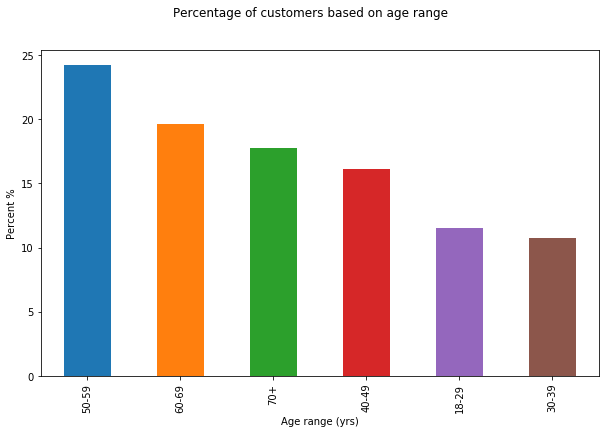

In [25]:
def create_chart(df, title, x_label, y_label, kind):
    '''
    Creates a bar chart with titlle and labeled axis
    
    INPUT: dataframe, title and x and y labels
    OUTPUT: bar chart
    '''
    df.plot(kind= kind, figsize=(10,6)) # plots bar chart
    plt.suptitle(title) # title of plot
    plt.xlabel(x_label) # label for x axis
    plt.ylabel(y_label); # label for y axis
    return


# plots bar chart
create_chart(age_percentage, 'Percentage of customers based on age range', 'Age range (yrs)', 'Percent %', 'bar')

- **Income range:**

34% of customers earn between \\$51,000 to \\$70,000 per year and it look likes most customers in general earn between \\$31,000 to \\$90,000 which accounts for 84.61%. This was not suprising to me. This is a considerable estimate of what happens in real business scenarios as these range of before have good buying power and are working class. Supprisingly I saw that those earning between \\$91,000 to \\$111,000+ per year were not close to half of the higher categories. Does this mean that people in this range do not buy coffee from starbuck directly? There might be other assumptions as well.

In [26]:
income_percentage = profile['income_range'].value_counts()/len(profile['income_range'])*100 # calculates the percentages of all income ranges
income_percentage # displays percentage

\$51,000 - $70,000     33.767285
\$31,000 - $50,000     26.617201
\$71,000 - $90,000     24.222597
\$91,000 - $110,000     8.013491
$111,000+               6.785835
\$30,000 and below      0.593592
Name: income_range, dtype: float64

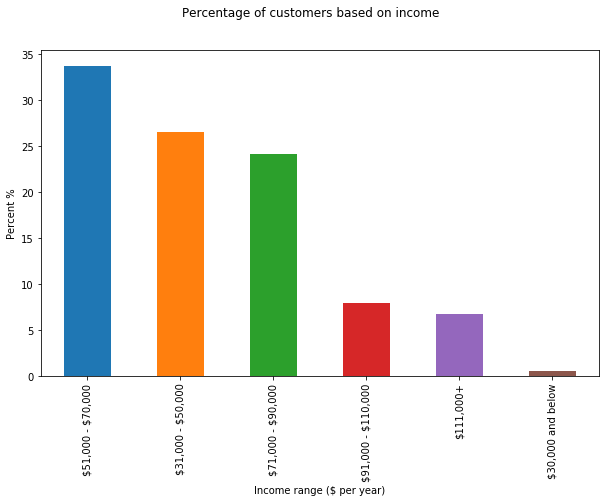

In [27]:
# plots a bar chart
create_chart(income_percentage, 'Percentage of customers based on income', 'Income range ($ per year)', 'Percent %', 'bar')

- **Subscription date:**

From the graph below you can see that customers generally increased with time although the there was big spike towards the end of 2017. This can be due to so many things like good economy, effective campaigns during that season creating more brand awareness etc. It drops in 2018 although it is generally higher than previous years before the spike.

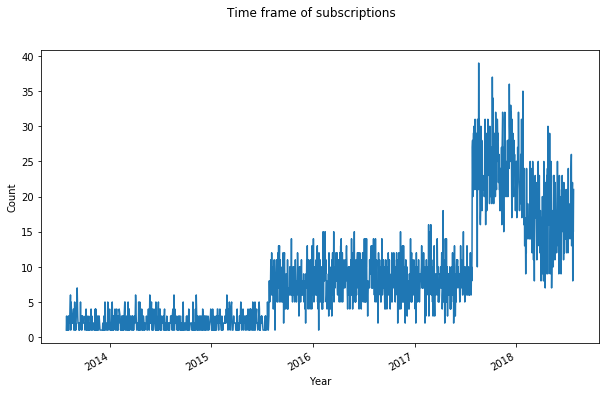

In [28]:
# plots a line chart
create_chart(profile['subscription_date'].value_counts(), 'Time frame of subscriptions', 'Year', 'Count', 'line')

- **Gender:**

For this dataset it is seen that Starbucks has more male customers accounting for 57% and females at 41%. Other genders account for less than 2%

In [29]:
gender_percentage = profile['gender'].value_counts()/len(profile['gender'])*100 # calculates the percentages of all income ranges
gender_percentage # displays percentage

M    57.227656
F    41.342327
O     1.430017
Name: gender, dtype: float64

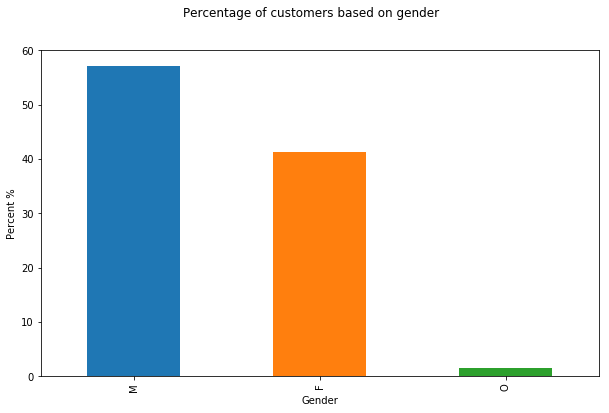

In [30]:
# plots a bar chart
create_chart(gender_percentage, 'Percentage of customers based on gender', 'Gender', 'Percent %', 'bar')

### Bi-variate analysis
This is analysis with more 2 variables.

- **Distribution of income by age range:**

The box plot below shows that at age range 18 - 29, the distribution is somewhat normal although it is slightly right skewed and overall shows that the income of that range of customers are closer together. Its median income is about \\$50,000 per year. For 30 - 39, it is right (positive) skewed with it median salary closer to \\$60,000. Age 40 - 49 there are 4 outlier observations who earn close to \\$120,000. It is skewed to the right and has a s=wider spread of observations when compared to the previous ages.

For the other age range, it can be said that they have are right skewed although they are close to being a normal distribution with median income around \\$70,000. Customer who are aged 60 - 69 have a median salary less than that of 50 - 59 and 70+ but is still close to the \\$70,000 mark. They both have a wide spread of data points.

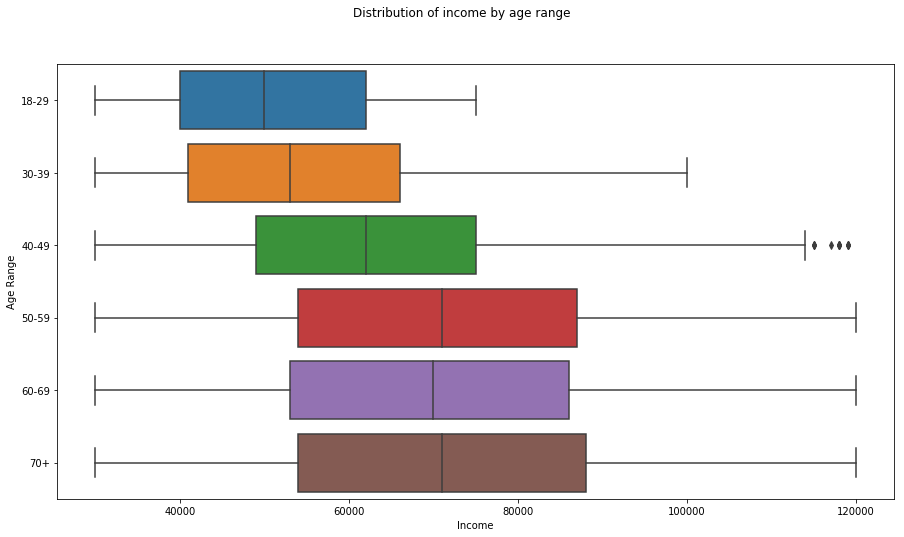

In [31]:
plt.figure(figsize=(15,8)) # adjusts the size of the boxplot
plt.suptitle('Distribution of income by age range') # title of plot
ax = sns.boxplot(x="income", y= "age_range", data = profile) # plots a boxplot
ax.set(xlabel = 'Income', ylabel = 'Age Range'); # labels the axis of boxplot

### Multivariate analysis:
This is an analysis with more than 2 variables. In this section the 'merged_df' dataframe is used as we are looking at each activitie without considering the unique user id.

- **Correlation heat map:**

For this data, there are no strong correlations found although income and age are the variable closer to 1.

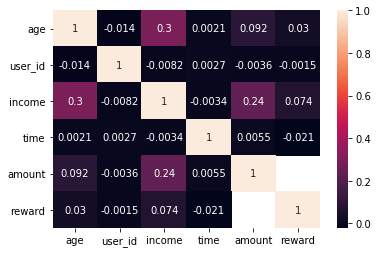

In [32]:
sns.heatmap(df.corr(), annot = True); # displays a correlation heat map

- **Event distribution based on gender and income:**
From the bar chart below it clearly shows that females received, viewed, completed offers and did more transaction than male or other genders. Males slightly completed more offers than other genders. Starbucks female customers earn more that males and other genders even when they are 57% male customers and 41% female customers.

**Note:** This is based on activities done by the unique customers. So 1 customer might interact with Starbucks offers more than 1 time.

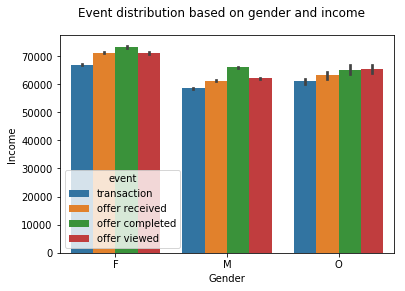

In [33]:
def create_seaborn_chart(df1, x_axis, y_axis, color, x_label, y_label, title):
    '''
    Creates a bar chart with seaborn library
    
    INPUT: dataframe, values for x and y axis, hue, labels for chart
    and title of chart
    
    OUTPUT: a bar chart
    '''
    ax = sns.barplot(x=x_axis, y=y_axis, hue=color, data=df1) # plots bar chart
    ax.set(xlabel=x_label, ylabel= y_label) # labels axis
    plt.suptitle(title); # title of plot
    return

# plot a bar chart
create_seaborn_chart(df, "gender", "income", "event", "Gender", "Income", "Event distribution based on gender and income")

- **Event distribution based on age range and income**
As age increases all events generally increase. This might be due to increase in buying power or that Starbucks has more customers between 40 to 70+ than they have between 18 to 39. All events are a bit proportional at each age range with offer completed being higher for each although the transactions for the age range 60 - 69 is slightly reduced compared to 50 - 59 and 70+ age range.

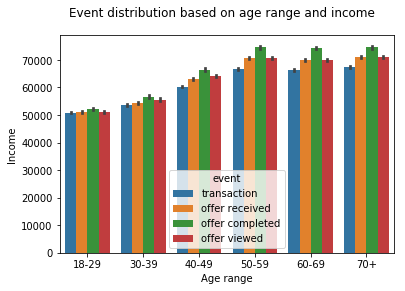

In [34]:
# plot a bar chart
create_seaborn_chart(df, "age_range", "income", "event", "Age range", "Income", "Event distribution based on age range and income")

## Customer Segementation
At this point of the project I have seen some general patterns in the data. It will be helpful to dig deep and uncover more details of the customer behaviour based on a stated demographics. For the dataset provided one can user either gender, income or age demographics to segment customers but for the purose of this project I chose to use income demographics as I thought it to be a better to know the spending power of their customers in order to distribute the targeted campaigns.

I segmented customers into 5 groups:
- Low Income: \\$30,000 and below
- Low Middle Income: \\$31,000 to \\$50,000
- Middle Income: \\$51,000 to \\$70,000
- Middle High Icome: \\$71,000 to \\$90,000
- High Income: \\$91,000 to \\$110,000 and \\$111,000 and above

With this segementation, one should be able to see:
- The number of customers in each group
- How much was spent
- Which gender spent more in each category
- Number of events (activities) done.
- Age range and events done. etc.

in order to understand hidden patterns

Also this will be used to know which demographic groups responded best to which offer type

In [35]:
# segmented groups based on income range criteria
low_income = df[(df['income_range'] == '\$30,000 and below')] 
low_middle_income = df[(df['income_range'] == '\$31,000 - $50,000')]
middle_income = df[(df['income_range'] == '\$51,000 - $70,000')]
mid_high_income = df[(df['income_range'] == '\$71,000 - $90,000')]
high_income = df[(df['income_range'] == '\$91,000 - $110,000') | (df['income_range'] == '$111,000+')]


# segmented groups based on income range criteria
low_income_offer = merged_df[(merged_df['income_range'] == '\$30,000 and below')] 
low_middle_income_offer = merged_df[(merged_df['income_range'] == '\$31,000 - $50,000')]
middle_income_offer = merged_df[(merged_df['income_range'] == '\$51,000 - $70,000')]
mid_high_income_offer = merged_df[(merged_df['income_range'] == '\$71,000 - $90,000')]
high_income_offer = merged_df[(merged_df['income_range'] == '\$91,000 - $110,000') | (merged_df['income_range'] == '$111,000+')]


### Low Income Demographics

This segment of Starbucks customers who earn \\$30,000 and below are grouped as low income because when compared to other income ranges in the dataset it is the least salary. This demographics has 88 customers with age ranging from 19 to 92 with 1,652 activities (events) consisting of 874 transactions. 396 offers were recieved  with 262 of those offers viewed accounting for 66% open rate and out of the 262 offers viewed, 120 offers were completed close to half (46%) of the offers viewed. Discount offers were recieved well by this group at 53%  (63) of completed offers and BOGO at 48% (57). Informational offers in this group were higher than the other offers 128

Total amount spent on transaction is \\$4,335.32 with males making most of these transaction. It seems that since males make the most transactions, more offers are sent to them. In this group there are more people aged between 18 to 29 with more males and less female compared to the second highest age range 50 to 59 which has more females compare to the former (18 to 29). People aged 70 and above are less here. Those 18 to 29 make more transactions followed by customers aged 50 to 59.

In [36]:
offers = portfolio.rename(columns = {'offer id': 'completed_offer_id'}) # renaming column

completed_offer = low_income.merge(offers, on = 'completed_offer_id') # merging dataframe
completed_offer[completed_offer['event'] == 'offer completed']['offer_type'].value_counts() # displays count of completed offers

discount    63
bogo        57
Name: offer_type, dtype: int64

In [87]:
#number of informational offers
low_income_offer[low_income_offer['offer_type'] == 'informational']['offer_type'].value_counts()

informational    128
Name: offer_type, dtype: int64

In [37]:
len(low_income['user_id'].unique()) # finds number of unique users

88

In [38]:
def counts(df, column_name, value):
    '''
    Gets the number of speified values in a column
    
    INPUT:
    df - data frame
    column_name - the column where the value resides
    value - the actual data we want to count
    '''
    count = len(df[df[column_name] == value]) # count of specified values
    return print(count) # prints the value

#calls counts function
counts(low_income, 'event', 'transaction')
counts(low_income, 'event', 'offer received')
counts(low_income, 'event', 'offer viewed')
counts(low_income, 'event', 'offer completed')

low_income.describe() # displays descriptive statistics for data frame

874
396
262
120


,age,user_id,income,time,amount,reward
count,1652.000000,1652.000000,1652.0,1652.000000,874.000000,120.000000
mean,47.716707,7825.322639,30000.0,364.329298,4.960320,4.225000
std,18.217433,4000.629990,0.0,202.009992,4.416026,2.247174
min,19.000000,29.000000,30000.0,0.000000,0.050000,2.000000
25%,33.000000,3980.000000,30000.0,180.000000,1.905000,2.000000
50%,47.000000,8522.000000,30000.0,408.000000,4.175000,5.000000
75%,62.000000,11522.000000,30000.0,522.000000,6.717500,5.000000
max,92.000000,14463.000000,30000.0,714.000000,63.300000,10.000000


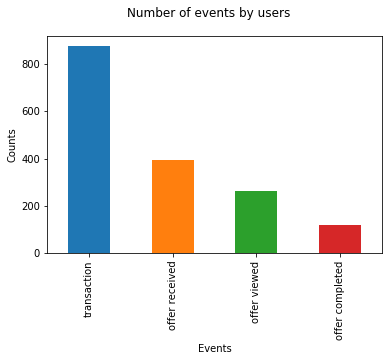

In [39]:
# plots a bar chart
create_chart(low_income['event'].value_counts(), 'Number of events by users', 'Events', 'Counts', 'bar')

In [39]:
def amount_spent_by_gender(df):
    '''
    Sums amount spent based on gender
    and prints out details of money spent
    by the demographics
    
    INPUT: dataframe
    OUTPUT: amount spent by each gender and total amout spent
    
    '''
    # finds sum and rounds up all amounts in the gender columns
    amnt_female = round(df[df['gender'] == 'F']['amount'].sum(), 2)
    amnt_male = round(df[df['gender'] == 'M']['amount'].sum(), 2)
    amnt_other = round(df[df['gender'] == 'O']['amount'].sum(), 2)
    Total = round(amnt_female + amnt_male + amnt_other, 2)

    # prints results
    print('The amount spent by females in this group is ${amnt_female}'.format(amnt_female = amnt_female ))
    print('The amount spent by males in this group is ${amnt_male}'.format(amnt_male = amnt_male))
    print('The amount spent by other gender in this group is ${amnt_other}'.format(amnt_other = amnt_other))
    print('----------------------------------------------------------')
    print('Total amount spent in this group is ${total}'.format(total = Total))
    
    return

amount_spent_by_gender(low_income)

The amount spent by females in this group is $1177.41
The amount spent by males in this group is $2939.43
The amount spent by other gender in this group is $218.48
----------------------------------------------------------
Total amount spent in this group is $4335.32


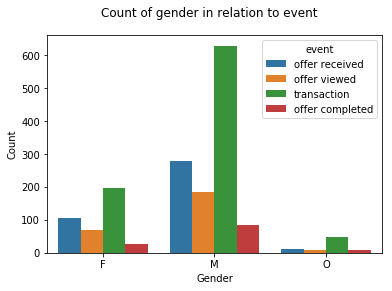

In [40]:
def create_countplot(df1, x_axis, color, x_label, y_label, title):
    '''
    Creates a bar chart with seaborn library
    
    INPUT: dataframe, values for x and y axis, hue, labels for chart
    and title of chart
    
    OUTPUT: a bar chart
    '''
    ax = sns.countplot(x=x_axis, hue=color, data=df1) # plots a bar chart 
    ax.set(xlabel=x_label, ylabel= y_label) # labels axis
    plt.suptitle(title); # title of plot

    return
    
# plots a grouped bar chart
create_countplot(low_income, "gender", "event", "Gender", "Count", "Count of gender in relation to event")

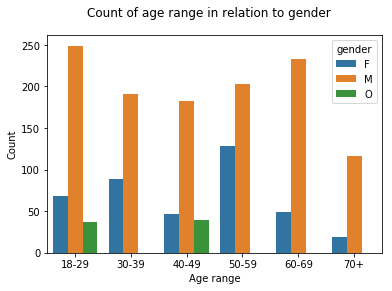

In [41]:
# plots a grouped bar chart
create_countplot(low_income, "age_range", "gender", "Age range", "Count", "Count of age range in relation to gender") 

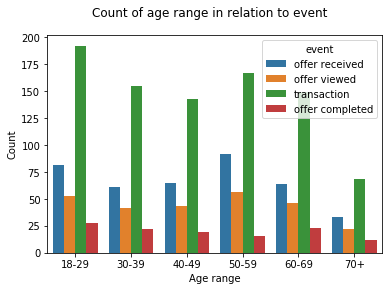

In [42]:
# plots a grouped bar chart
create_countplot(low_income, "age_range", "event", "Age range", "Count", "Count of age range in relation to event")

### Low to Middle Income Demographics

This segment of Starbucks customers earn between \\$31,000 to \\$50,000 and are grouped as low middle income. This a bit higher than the low income group but still encompases people who earn a low income compared to the salaries above it. This demographics has 3,946 customers with age ranging from 18 to 101 and average age of 48. This group accounts for 75,791 activities (events) consisting of 39,461 transactions. 17,715 offers were recieved with 12,183 of those offers viewed accounting for 69% open rate and out of the 12,183 offers viewed, 6,432 offers were completed making 53% of the offers viewed.
Discount offers got more response by this group at 56%  (3,606) of completed offers and BOGO at 44% (2,826). Informational offers in this group were higher than the other offers 5,762

Total amount spent on transaction is \\$271,027.79 with males making most of these transaction at \\$162,228.63 and females \\$105,206.98. It still seems that since males make the most transactions, more offers are sent to them same as low income group. The majority of people are aged between 18 to 29 do more transactions followed by 50 - 59 just like that of low income group.

In [43]:
completed_offer = low_middle_income.merge(offers, on = 'completed_offer_id') # merging dataframe
completed_offer[completed_offer['event'] == 'offer completed']['offer_type'].value_counts() # displays count of completed offers

discount    3606
bogo        2826
Name: offer_type, dtype: int64

In [86]:
#number of informational offers
low_middle_income_offer[low_middle_income_offer['offer_type'] == 'informational']['offer_type'].value_counts()

informational    5762
Name: offer_type, dtype: int64

In [44]:
len(low_middle_income['user_id'].unique()) # finds number of unique users

3946

In [45]:
#calls counts function
counts(low_middle_income, 'event', 'transaction')
counts(low_middle_income, 'event', 'offer received')
counts(low_middle_income, 'event', 'offer viewed')
counts(low_middle_income, 'event', 'offer completed')

low_middle_income.describe() # displays descriptive statistics for data frame

39461
17715
12183
6432


,age,user_id,income,time,amount,reward
count,75791.000000,75791.000000,75791.000000,75791.000000,39461.000000,6432.000000
mean,48.035637,7472.809436,40263.962740,367.936061,6.868244,4.574005
std,18.591669,4209.436826,5889.463356,200.888431,16.176931,2.698410
min,18.000000,7.000000,31000.000000,0.000000,0.050000,2.000000
25%,32.000000,3884.000000,35000.000000,192.000000,1.950000,2.000000
50%,47.000000,7520.000000,40000.000000,408.000000,4.570000,5.000000
75%,62.000000,11082.000000,45000.000000,534.000000,8.860000,5.000000
max,101.000000,14824.000000,50000.000000,714.000000,454.620000,10.000000


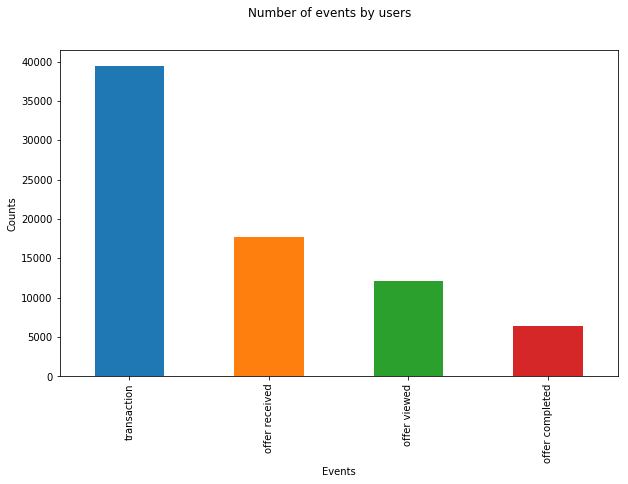

In [46]:
# plots bar chart
create_chart(low_middle_income['event'].value_counts(), 'Number of events by users', 'Events', 'Counts', 'bar')

In [47]:
amount_spent_by_gender(low_middle_income)

The amount spent by females in this group is $105206.98
The amount spent by males in this group is $162228.63
The amount spent by other gender in this group is $3592.18
----------------------------------------------------------
Total amount spent in this group is $271027.79


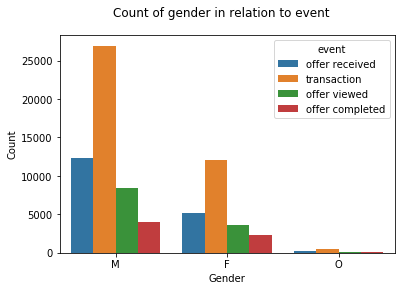

In [48]:
# plots a grouped bar chart
create_countplot(low_middle_income, "gender", "event", "Gender", "Count", "Count of gender in relation to event")

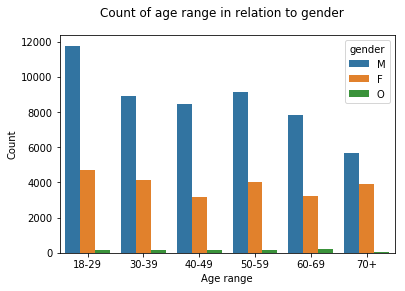

In [49]:
# plots a grouped bar chart
create_countplot(low_middle_income, "age_range", "gender", "Age range", "Count", "Count of age range in relation to gender")

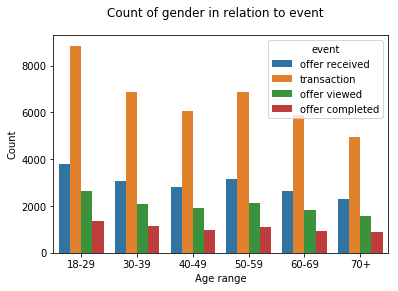

In [50]:
# plots a grouped bar chart
create_countplot(low_middle_income, "age_range", "event", "Age range", "Count", "Count of gender in relation to event")

### Middle Income Demographics

This segment of Starbucks customers earn between \\$51,000 to \\$70,000 and are grouped as middle income customers. This demographics has 5,006 customers with age ranging from 18 to 101 and average age of 48. This group accounts for 95,623 events consisting of 44,842 transactions. 22,495 offers were recieved with 17,671 of those offers viewed accounting for 79% open rate and out of the 17,671 offers viewed, 10,615 offers were completed making 60% of the viewed offers. Discount offers got more response by this group at 53%  (5,655) of completed offers and BOGO at 47% (4,960). Informational offers in this group were higher than the other offers 8,027

Total amount spent on transaction is \\$525,708.12 with males making most of these transaction at \\$283,007.82 and females \\$231,965.85. It still seems that since males make the most transactions, more offers are sent to them same as previous groups also generally the number of transactions for females and events have increased compared to the demographics before this. The majority of people aged between 50 to 59 do more transactions followed by 40 - 49. In this group the 18 - 29 age range has reduced and an increased female presence in all age ranges compared to the previous income demographics.

In [51]:
completed_offer = middle_income.merge(offers, on = 'completed_offer_id') # merging dataframe
completed_offer[completed_offer['event'] == 'offer completed']['offer_type'].value_counts() # displays count of completed offers

discount    5655
bogo        4960
Name: offer_type, dtype: int64

In [85]:
#number of informational offers
middle_income_offer[middle_income_offer['offer_type'] == 'informational']['offer_type'].value_counts()

informational    8027
Name: offer_type, dtype: int64

In [52]:
len(middle_income['user_id'].unique()) # finds number of unique users

5006

In [53]:
# calls the counts function
counts(middle_income, 'event', 'transaction')
counts(middle_income, 'event', 'offer received')
counts(middle_income, 'event', 'offer viewed')
counts(middle_income, 'event', 'offer completed')

middle_income.describe() # displays descriptive statistics for data frame

44842
22495
17671
10615


,age,user_id,income,time,amount,reward
count,95623.000000,95623.000000,95623.000000,95623.000000,44842.000000,10615.000000
mean,51.830125,7400.841022,60128.703345,366.711482,11.723565,4.894489
std,17.646475,4330.120191,5792.204540,200.627149,24.529901,2.878840
min,18.000000,3.000000,51000.000000,0.000000,0.050000,2.000000
25%,39.000000,3638.000000,55000.000000,186.000000,3.460000,2.000000
50%,52.000000,7357.000000,60000.000000,408.000000,9.870000,5.000000
75%,64.000000,11222.000000,65000.000000,534.000000,15.830000,5.000000
max,101.000000,14821.000000,70000.000000,714.000000,723.100000,10.000000


In [54]:
amount_spent_by_gender(middle_income)

The amount spent by females in this group is $231965.85
The amount spent by males in this group is $283007.82
The amount spent by other gender in this group is $10734.45
----------------------------------------------------------
Total amount spent in this group is $525708.12


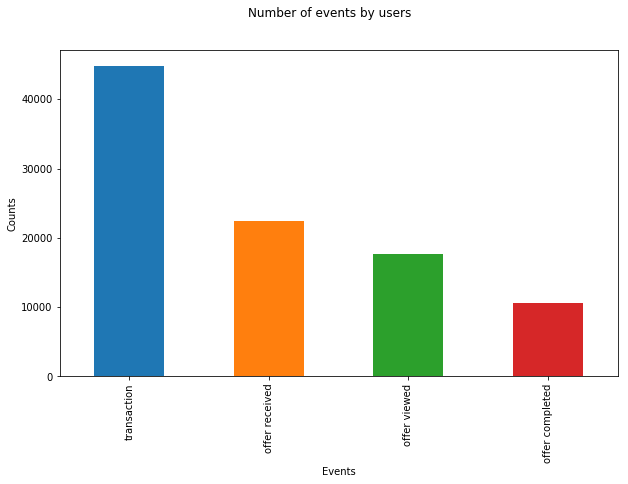

In [55]:
# plots bar chart
create_chart(middle_income['event'].value_counts(), 'Number of events by users', 'Events', 'Counts', 'bar')

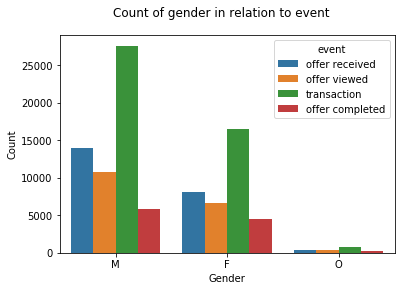

In [56]:
# plots a grouped bar chart
create_countplot(middle_income, "gender", "event", "Gender", "Count", "Count of gender in relation to event")

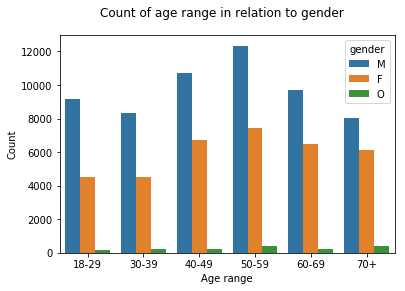

In [57]:
# plots a grouped bar chart
create_countplot(middle_income, "age_range", "gender", "Age range", "Count", "Count of age range in relation to gender")

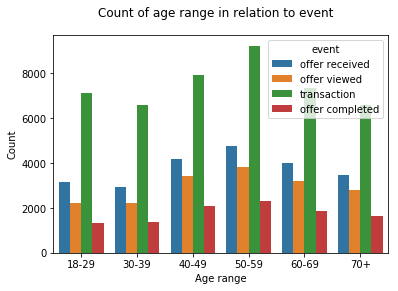

In [58]:
# plots a grouped bar chart
create_countplot(middle_income, "age_range", "event", "Age range", "Count", "Count of age range in relation to event")

### Middle to High Income Demographics

This segment of Starbucks customers earn between \\$71,000 to \\$90,000 and are grouped as middle income customers. This demographics has 3,591 customers with age ranging from 18 to 101 and average age of 59. This group accounts for 63,044 events consisting of 25,183 transactions. 16,081 offers were recieved with 12,508 of those offers viewed accounting for 77% open rate and out of the 12,508 offers viewed, 9,272 offers were completed making 74% of the viewed offers. Discount offers got more response by this group at 52%  (4,832) of completed offers and BOGO at 48% (4,440). Informational offers in this group were higher than the other offers 5,442

Total amount spent on transaction is \\$528,815.41 with females making most of these transaction at \\$286,516.63 and males \\$234,438.02. For this segment of customers, transaction is closely tied although females make slightly more transactions than males. The majority of people aged between 50 to 59 do more transactions and it is seen that from ages 50 down to 70+ females are more than males but from 18 to 49 males are more. The number of customers between 18 and 29 decrease more when compared to previous income demographics.

In [59]:
completed_offer = mid_high_income.merge(offers, on = 'completed_offer_id') # merging dataframe
completed_offer[completed_offer['event'] == 'offer completed']['offer_type'].value_counts() # displays count of completed offers

discount    4832
bogo        4440
Name: offer_type, dtype: int64

In [84]:
#number of informational offers
mid_high_income_offer[mid_high_income_offer['offer_type'] == 'informational']['offer_type'].value_counts()

informational    5442
Name: offer_type, dtype: int64

In [60]:
len(mid_high_income['user_id'].unique()) # finds number of unique users

3591

In [61]:
# calls the counts function
counts(mid_high_income, 'event', 'transaction')
counts(mid_high_income, 'event', 'offer received')
counts(mid_high_income, 'event', 'offer viewed')
counts(mid_high_income, 'event', 'offer completed')

mid_high_income.describe() # displays descriptive statistics for data frame

25183
16081
12508
9272


,age,user_id,income,time,amount,reward
count,63044.000000,63044.000000,63044.000000,63044.000000,25183.000000,9272.000000
mean,58.687266,7357.564082,78685.473637,366.173593,20.998904,5.102675
std,15.175538,4263.545976,5947.632796,199.957584,40.500334,2.986943
min,18.000000,8.000000,71000.000000,0.000000,0.050000,2.000000
25%,50.000000,3626.000000,73000.000000,186.000000,13.700000,2.000000
50%,58.000000,7317.000000,78000.000000,408.000000,19.040000,5.000000
75%,68.000000,11028.000000,84000.000000,528.000000,24.220000,5.000000
max,101.000000,14825.000000,90000.000000,714.000000,1015.730000,10.000000


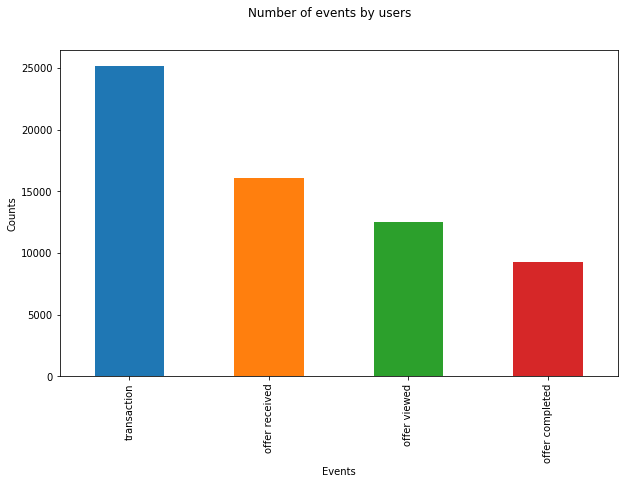

In [62]:
# plots bar chart
create_chart(mid_high_income['event'].value_counts(), 'Number of events by users', 'Events', 'Counts', 'bar')

In [63]:
amount_spent_by_gender(mid_high_income)

The amount spent by females in this group is $286516.63
The amount spent by males in this group is $234438.02
The amount spent by other gender in this group is $7860.76
----------------------------------------------------------
Total amount spent in this group is $528815.41


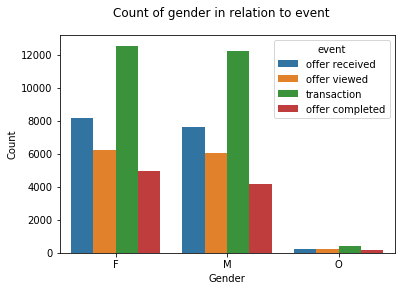

In [64]:
# plots a grouped bar chart
create_countplot(mid_high_income, "gender", "event", "Gender", "Count", "Count of gender in relation to event")

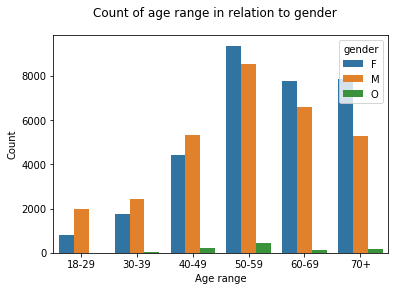

In [65]:
# plots a grouped bar chart
create_countplot(mid_high_income, "age_range", "gender", "Age range", "Count", "Count of age range in relation to gender")

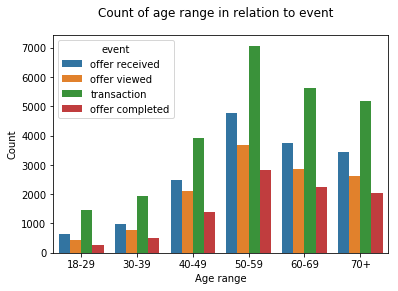

In [68]:
# plots a grouped bar chart
create_countplot(mid_high_income, "age_range", "event", "Age range", "Count", "Count of age range in relation to event")

### High Income Demographics

This segment of Starbucks customers earn between \\$91,000 to \\$110,000 and \\$111,000+ and are grouped as high income customers. This demographics has 2,194 customers with age ranging from 36 to 101 and average age of 63. This group accounts for 36,652 events consisting of 13,597 transactions. 9,814 offers were recieved with 7,236 of those offers viewed accounting for 74% open rate and out of the 7,236 offers viewed, 6,005 offers were completed making 83% of the viewed offers. Discount offers got more response by this group at 50.5%  (3,030) of completed offers and BOGO at 49.5% (2,975). Informational offers in this group were higher than the other offers 3,301

Total amount spent on transaction is \\$405,055.76 with females making most of these transaction at \\$238,828.13 and males spending less at \\$162,276.96. Unlike other groups, females are more than males with more transactions being completed by females. The majority of people aged between 50 to 59 do more transactions followed by 70+ age range which is slightly higher than the 60 - 69 age group. In this group there are no customers between 18 - 29 and a small number of customers in the 30 - 39 range.

In [69]:
completed_offer = high_income.merge(offers, on = 'completed_offer_id') # merging dataframe
completed_offer[completed_offer['event'] == 'offer completed']['offer_type'].value_counts() # displays count of completed offers

discount    3030
bogo        2975
Name: offer_type, dtype: int64

In [83]:
#number of informational offers
high_income_offer[high_income_offer['offer_type'] == 'informational']['offer_type'].value_counts()

informational    3301
Name: offer_type, dtype: int64

In [70]:
len(high_income['user_id'].unique()) # finds number of unique users

2194

In [71]:
# calls the count function
counts(high_income, 'event', 'transaction')
counts(high_income, 'event', 'offer received')
counts(high_income, 'event', 'offer viewed')
counts(high_income, 'event', 'offer completed')

high_income.describe() # displays descriptive statistics for data frame

13597
9814
7236
6005


,age,user_id,income,time,amount,reward
count,36652.000000,36652.000000,36652.000000,36652.000000,13597.000000,6005.000000
mean,63.029766,7398.684137,101963.030667,365.183619,29.790083,5.220150
std,12.144621,4313.978231,8419.411761,199.170398,53.822586,3.001525
min,36.000000,1.000000,91000.000000,0.000000,6.220000,2.000000
25%,54.000000,3684.000000,95000.000000,186.000000,20.860000,2.000000
50%,61.000000,7434.000000,99000.000000,408.000000,25.480000,5.000000
75%,71.000000,10999.000000,109000.000000,528.000000,30.600000,5.000000
max,101.000000,14820.000000,120000.000000,714.000000,1062.280000,10.000000


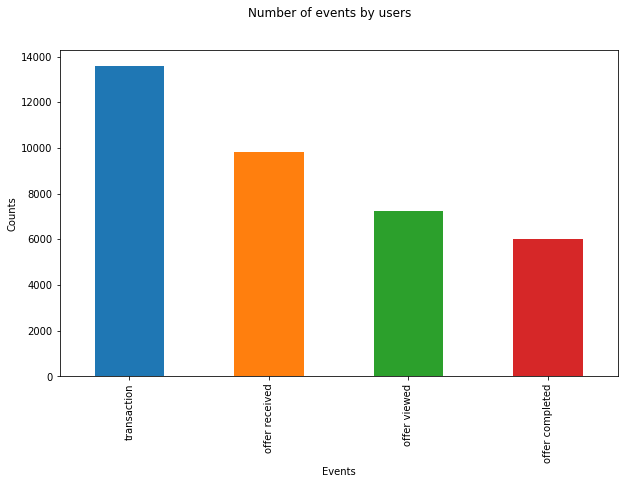

In [72]:
# plots bar chart
create_chart(high_income['event'].value_counts(), 'Number of events by users', 'Events', 'Counts', 'bar')

In [73]:
amount_spent_by_gender(high_income)

The amount spent by females in this group is $238828.13
The amount spent by males in this group is $162276.96
The amount spent by other gender in this group is $3950.67
----------------------------------------------------------
Total amount spent in this group is $405055.76


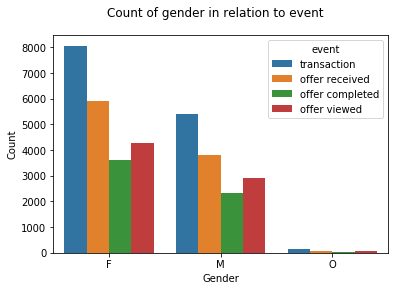

In [74]:
# plots a grouped bar chart
create_countplot(high_income, "gender", "event", "Gender", "Count", "Count of gender in relation to event")

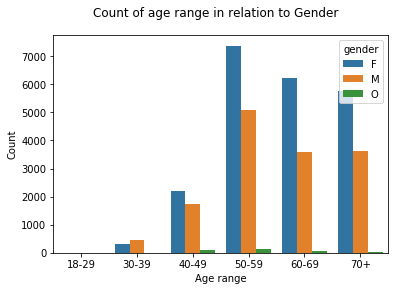

In [75]:
# plots a grouped bar chart
create_countplot(high_income, "age_range", "gender", "Age range", "Count", "Count of age range in relation to Gender")

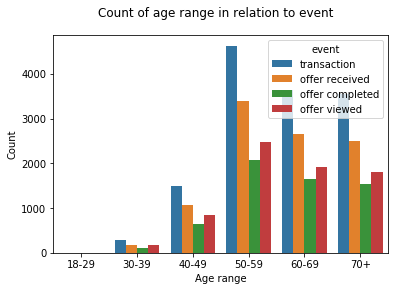

In [76]:
# plots a grouped bar chart
create_countplot(high_income, "age_range", "event", "Age range", "Count", "Count of age range in relation to event")

# Conclusion
In conclusion, segementing customers can help in understand a particular target audience and creating personas along empathy maps to successful create a profile for the kind of customers Starbuck will like to attract. For this project the idea was geard towards looking at customers that have buying power and are willing to pay for cup of coffee or other products to ensure sustained sales. I went from understanding each component to comparing two to three components and found out that with increased age, there were more transactions. Also with increase age saw an increase in income. This can be due to advancement in career (i.e the more years spent in a field, the more you are paid). Between low income to middle income, males earned more and made more transactions but from middle to high icome and high income demographics, there were more females and they contributed higher to trasactions. These customers responded better to discount campaigns than BOGO campaigns.Segementing by income was the best way to look at other demographics putting sales in mind. The Starbucks brand has to stay alive in the minds of both the young and the elderly and there's no better way than to target their specific needs than to attempt sending various campaigns.

# Discussion and recommendations

A business is looking for paying customers in order to run its operations but yet needs to attract more customers and convert them. The type of campaign to assign to each group will vary based on the business goal of the organization. If it's a campaign to drive loyalty, sales, gain new customers or reactivate and convert the already existing customer base which doesn't spend as much on products. For the purpose of this project it is assumed that this campaign is drive more sales with the existing campaign option, BOGO, Discount and Informational.


**Low Income Demographics:**

For this group **dicounts and BOGO** is a quick way to jump start sales as it creates urgency and added incentive for people to buy. At a 66% open rate and 46% complete rate it might be a risky bet to see how many will be converted. This can also serve as a campaign to get more young customers between 18 to 29 since they are prominent in this group and probably starting out their careers. With a good marketing strategy, this target audience can be converted since they’re great at sparking interest in new products. Discounts will be great because of the low number of customers in this group. If so much discount is given to a large proportion of the customers, it can reduce a company's marginal profit.

Possible channels great for this are email, mobile, social.


**Low to Middle Income Demographics:**

This is the second largest group after middle income with 3,946 customers over the stated time period. There is a 66% open rate and 53% of offers completed. This shows that these customers are more invested in the Starbucks brand and are willing to buy. For this group, **BOGO** will should be given to females to increase the number of transactions from them and **informational campaign** to males, to keep the brand alive in their minds. This could be done by sharing males and targeting them with social media ads.

**Middle Income Demographics:**

This accounts for the most number of customer base. With 79% of open rate and 60% of completing offers, it is more likely that these customers will check offers. This group especially those customer between 50 to 59 are already invested in the brand and **BOGO** campaign tagergeted to females will increase number of products solds and attract more female customers in this group. For the male customers 70:40 share of **informational and discount campaign** should be targeted at them. This will be done to keep the brand in their mind and give discount to those who haven't done as much transaction as others. Web, email, mobile, social are channels that can be used to target this demographics.


**Middle to High Income Demographics:**

These are high paying customers with more females making transactions than males. This group has a 74% of completed offers. For a sales campaign, **BOGO** will be a great campaign to drive more sales. Starbucks will like to get more customers in this category and middle income so this should be effective in getting that goal. Email, mobile, social can be used to reach them


**High Income Demographics:**

This group probably consists of senior management and people who have been in their career for a long time. With high open rate and offer completion rate, this group of people might be looking for ways to get good deals in order to save money. To help solve that and get more customer loyalty a random slection of **informational and discount** offer can be sent to female customers and then **BOGO** sent to male customers to increase their transaction rate. The 50 to 59 age range is an important customer base and most of the levels of income per year and Starbucks will have to keep them happy while attracting more around this age range. Web, email, mobile, social are channels are great channels for this.

# Reflection

I found this project particularly interesting as I have knowledge of digital marketing and found out how much data science can help to make my work a lot more easier by undertanding the customers better. For datasets with more information, one can segment further and find intriguing details on the customers being targeted.

Exploratory data analysis on the surface doesn't look difficult but when one dives deep into exploring the data, it's a continuous process which takes time to understand and interpret. To improve this project, I could go further to create a model although I wanted this to help me exercise my exploratory data analytics skills. Going forward, I will practice more of this in addition with my digital marketing skills.